# EDA.Prediction ratings of hotels(modeling).

In [365]:
import pandas as pd
import numpy as np 

# импортируем библиотеки для визуализации
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline

# Добавил 
from sklearn import preprocessing   # библиотека для нормализации
import requests                     # для парсинга сайтов
from data.personal import api_key   # сторонняя библиотека
import category_encoders as ce      # для кодирования признаков
import re                           # регулярные выражения
import time                         # время для сокращения кода и скорости выполнения
import datetime                     # библиотека, чтобы дату перевести в секунды

In [366]:
# Измерим время выполнения всего проекта
start_time = time.time()

Призаки которые будут добавлены или убраны из модели. 1 - значит, что признак будет участвовать в предсказании модели, 0 - не будет.

В словаре *features* занесены все признаки которые участвуют в построении предсказательной модели. Для точности предсазания, можно добавить или убрать признак из нашей модели, где 0 (признак не участвует) или 1 (признак участвует). 

In [367]:
# Новые признаки.
# Значения их вывода.
features = {
'country_i': 0,                     # не улучшает модель
'famous_hotels': 0,                 # не улучшает модель
'hotel_name_i': 0,                  # не улучшает модель
'review_date_month' : 0,            # слабо улучшает модель   1
'match_by_nationality': 0,          # улучшает модель
'days_since_review': 0,             # очень слабо улучшает модель
'pos_category_i': 0,                # хорошо улучшает модель  1
'neg_category_i': 0,                # хорошо улучшает модель  1
'tags_importance':0,                # хорошо улучшает модель  1
'center_hotel_km': 0,               # не улучшает модель      1
'weather': 1,                       # не улучшает модель
'tonality_of_posetive_review': 0 ,  # лидер улучшения модели  1
'tonality_of_negative_review': 0 ,  # сильно улучшает модель  1
}

In [368]:
# Заносим значения для каждого признака.
# Условия вывода признаков.
for key,value in features.items():
    # Порядковой кодирование признака country(страны)
    if key == 'country_i': country_i = value
    # Famous_hotels - популярные отели.
    elif key == 'famous_hotels': famous_hotels = value
    # Порядковой кодирование признака hotel_name(названия отеля)
    elif key == 'hotel_name_i': hotel_name_i = value
    # Месяц в котором был данн отзыв.
    elif key == 'review_date_month': review_date_month = value
    # Страна рецензента reviewer_nationality
    elif key == 'match_by_nationality': match_by_nationality = value
    # Количество дней между датой проверки и датой очистки.
    elif key == 'days_since_review': days_since_review = value  # улучшил модель
    # Создание групп разных категорий на основе признака'positive_review'.
    elif key == 'pos_category_i': pos_category_i = value
    # Создание групп разных категорий на основе признака'negative_review'.
    elif key == 'neg_category_i': neg_category_i = value
    # Коффициент совокупности значимости тега.
    elif key == 'tags_importance': tags_importance = value
    # Растояние между центром города и отелем, в км.
    elif key == 'center_hotel_km': center_hotel_km = value     # нет существенных улучшений модели
    # Климатические условия в момент отзыва.
    elif key == 'weather': weather = value
    # Тональность текста в позетивном отзыве.
    elif key == 'tonality_of_posetive_review':
        tonality_of_posetive_review = value
    # Тональность текста в негативном отзыве
    elif key == 'tonality_of_negative_review':
        tonality_of_negative_review = value


## I. Постановка проблеммы 

**Description**:
Представьте, что вы работаете датасаентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов нахождения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель играет нечестно, и его стоит проверить.

**Цель проекта:** 
Построение модели максимально точно предсказывающую рейтиг отеля.

**Evaluation:**
Метрика качества оцениваются по метрике MAPE.

## II. Описание данных первичная оценка.

Компания *Booking* предоставила информацию в 3 файлах:

- *hotels_train.csv* - набор данных для обучения
- *hotels_test.csv* - набор данных для оценки качества
- *submission.csv* - файл сабмишна в нужном формате

1. Первоначальная версия датасета *hotels_train.csv* содержит 17 полей со следующей информацией:

- *hotel_address* — адрес отеля;
- *review_date* — дата, когда рецензент разместил соответствующий отзыв;
- *average_score* — средний балл отеля, рассчитанный на основе последнего комментария за последний год;
- *hotel_name* — название отеля;
- *reviewer_nationality* — страна рецензента;
- *negative_review* — отрицательный отзыв, который рецензент дал отелю;
- *review_total_negative_word_counts* — общее количество слов в отрицательном отзыве;
- *positive_review* — положительный отзыв, который рецензент дал отелю;
- *review_total_positive_word_counts* — общее количество слов в положительном отзыве.
- *reviewer_score* — оценка, которую рецензент поставил отелю на основе своего опыта;
- *total_number_of_reviews_reviewer_has_given* — количество отзывов, которые рецензенты дали в прошлом;
- *total_number_of_reviews* — общее количество действительных отзывов об отеле;
- *tags* — теги, которые рецензент дал отелю;
- *days_since_review* — количество дней между датой проверки и датой очистки;
- *additional_number_of_scoring* — есть также некоторые гости, которые просто поставили оценку сервису, но не оставили отзыв. Это число указывает, сколько там действительных оценок без проверки.
- *lat* — географическая широта отеля;
- *lng* — географическая долгота отеля.

2. Датасет *hotels_test.csv* содержит такую же информацию, за исключением признака *average_score*. Данный признак наша модель должна заполнить сама после обучения.

3. Датасет *submission.csv* содержит форму нужного формата, которую компания *Booking* ждёт от нас как результат работы данного проекта.

Рассмотрим данные подробнее.


In [369]:
# Подгрузим наши данные.
DATA_DIR = 'data/'
# датасет для обучения
df_train = pd.read_csv(DATA_DIR+'hotels_train.csv')
# датасет для предсказания  
df_test = pd.read_csv(DATA_DIR+'hotels_test.csv') 
# самбмишн 
sample_submission = pd.read_csv(DATA_DIR+'/submission.csv')  

In [370]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 386803 entries, 0 to 386802
Data columns (total 17 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               386803 non-null  object 
 1   additional_number_of_scoring                386803 non-null  int64  
 2   review_date                                 386803 non-null  object 
 3   average_score                               386803 non-null  float64
 4   hotel_name                                  386803 non-null  object 
 5   reviewer_nationality                        386803 non-null  object 
 6   negative_review                             386803 non-null  object 
 7   review_total_negative_word_counts           386803 non-null  int64  
 8   total_number_of_reviews                     386803 non-null  int64  
 9   positive_review                             386803 non-null  object 
 

Данные состоят:
- 8 объектных признаков;
- 9 числовых;
- всего 17 колонок и 386803 строк.

В признаках *lat* и *lng* есть пропущеные значения.

In [371]:
df_train.head(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,lat,lng
0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,51.507894,-0.143671
1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,51.521009,-0.123097


In [372]:
df_test.tail(2)

,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,tags,days_since_review,lat,lng
128933,Corso Concordia 1 Milan City Center 20129 Mila...,159,12/26/2015,9.0,Ch teau Monfort Relais Ch teaux,Australia,No Negative,0,1053,Staff very polite and helpful Hotel well loca...,20,7,"[' Leisure trip ', ' Solo traveler ', ' Execut...",586 day,45.468236,9.207380
128934,202 rue de Rivoli 1st arr 75001 Paris France,297,12/23/2015,8.0,Saint James Albany Paris Hotel Spa,United Kingdom,rooms were very dated and old fashion,8,2868,No Positive,0,1,"[' Leisure trip ', ' Couple ', ' Standard Room...",589 day,48.864269,2.330818


In [373]:
sample_submission.head(2)

,reviewer_score,id
0,8.679,488440
1,7.736,274649


In [374]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128935 entries, 0 to 128934
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   reviewer_score  128935 non-null  float64
 1   id              128935 non-null  int64  
dtypes: float64(1), int64(1)
memory usage: 2.0 MB


Объединим временно *df_train* c *df_test*, для последующей обработки. 

>❗Важно помнить, что индксы строк должны оставаться прежними, как и количество строк. 

Чтобы данные не перепутались добавим новый признак *test*, где 0 - нет, 1 - да.

In [375]:
df_train['test'] = 0
df_test['test'] = 1
# Объединяем в обую таблицу
rating_hotels = pd.concat([df_train, df_test])

# Сохраним индек как признак index_1
rating_hotels.reset_index(inplace=True)

In [376]:
rating_hotels.shape

(515738, 19)

Как результат видно, число строк теперь 515738, и добавилься новый признак *test*, а
по индексу 1 выводится сразу две строки, т.к. он повторятся.

## III. ОЧИСТКА ДАННЫХ

### 1. Пропуски.
Рассмотрим пропуски детальтно.

In [377]:
df = rating_hotels.isnull().mean() * 100
cols_with_null = df[df > 0].sort_values(
    ascending=False).drop('reviewer_score', axis=0)
display(cols_with_null)

lat    0.633655
lng    0.633655
dtype: float64

В признаках *lat и lng* есть пропуски, менее одного процента. Заполим их.


Для заполнния географических координат используем сайт https://yandex.ru/maps/.

Так как данных много, считывание данных было произведено не за один день. Данные были занесены с помощью функции *fetch_coordinates*, далее занесены в *rating_hotels*. Для дальейшего использования создан промежуточный файл *cordinats.csv* уже с заполнеными признаками *lat* и *lng*. 
Чтобы код работал исправно, часть кода была закоментирована.

In [378]:
def fetch_coordinates(address, apikey):
    """Функция для получения географических координат.

    Args:
        address (_str_): адресс отеля "hotel_addres"
        apikey (_str_): api-ключ

    Returns:
        _tuple_: кортеж значений долгота, широта
    """

    apikey_maps = apikey
    base_url = "https://geocode-maps.yandex.ru/1.x"
    response = requests.get(base_url, params={
        "geocode": address,
        "apikey": apikey_maps,
        "format": "json",
    })
    response.raise_for_status()
    found_places = response.json(
    )['response']['GeoObjectCollection']['featureMember']

    if not found_places:
        return None

    most_relevant = found_places[0]
    lon, lat = most_relevant['GeoObject']['Point']['pos'].split(" ")
    return lon, lat

In [379]:
# Пример работы кода
adress = 'Annagasse 7 01 Innere Stadt 1010 Vienna Austria'
coordinates = fetch_coordinates(adress, api_key['geocode_maps'])
print(coordinates)

('16.372721', '48.204235')


Заполним таблицу недостоющими координатами. В переменную *api_limit* записывае число обращений к сайту. Надо не забывать, что число скачиваний не должно превышать 1000 запросов в день.(Это правило бесплатного использования ресурса.)

In [380]:
# Ограничение на поиск по api запросам в день 1000.
api_limit = 0

# Оставляем данные у которых координаты не определены.
data = rating_hotels[rating_hotels['lng'].isnull() |
                     rating_hotels['lat'].isnull()]

# Добавим временный столбец coordinates с пустыми значениями.
data['coordinates'] = np.nan

# Apikey
key = api_key['geocode_maps']

# Eсли есть данные без координат и есть бесплатные запросы.
if len(data) > 0 and api_limit > 0:

    for i in range(api_limit):
        data['coordinates'].iloc[i] = fetch_coordinates(
            address=data['hotel_address'].iloc[i], apikey=key)

    api_limit = 0

C:\Users\AAPun\AppData\Local\Temp\ipykernel_15172\2873537343.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [381]:
# Остовляем строки только с значениями в столбце coordinates.
data = data[data['coordinates'].notnull()]

# Заносим данные в столбец lat lng из столбца coordinates.
data['lat'] = data['coordinates'].apply(lambda x: x[1])
data['lng'] = data['coordinates'].apply(lambda x: x[0])

# Удаляем столбец coordinates
data.drop(['coordinates'], axis=1, inplace=True)

# Номера дублирующих строк.
duplicate_rows = list(data.index)

# Удалим строки для которых найдены координаты.
rating_hotels.drop(index=duplicate_rows, axis=0, inplace=True)
# Объединим в один Dataframe.
rating_hotels = pd.concat([rating_hotels, data])

Данные были получены не за один раз поэтому они были занесены в файл *cordinates.csv*. Считаем их.

In [382]:
rating_hotels = pd.read_csv('data/cordinates.csv')
# Остались ли пропуски в координатах.
rating_hotels[['lat', 'lng']].isnull().mean()

lat    0.0
lng    0.0
dtype: float64

Как результат пропусков  в координатах не осталось.

### 2. Дубликаты.

In [383]:
test = rating_hotels.copy()
test.drop(['index'], axis=1, inplace=True)
test.duplicated().value_counts()

False    515402
True        336
dtype: int64

У нас 336 дубликатов, мы оставим их, так как если удалим, то финальное решение *submission* может исказиться.

### 3. Выбросы.

Рассмотрим все числовые признаки, кроме 'index','lat','lng','test'.

In [384]:
rating_hotels.drop(['index', 'lat', 'lng', 'test'], axis=1).describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,386803.000000
mean,498.081836,8.397487,18.539450,2743.743944,17.776458,7.166001,8.396906
std,500.538467,0.548048,29.690831,2317.464868,21.804185,11.040228,1.636090
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,2.500000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,7.500000
50%,341.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,8.800000
75%,660.000000,8.800000,23.000000,3613.000000,22.000000,8.000000,9.600000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000


Построим графики.

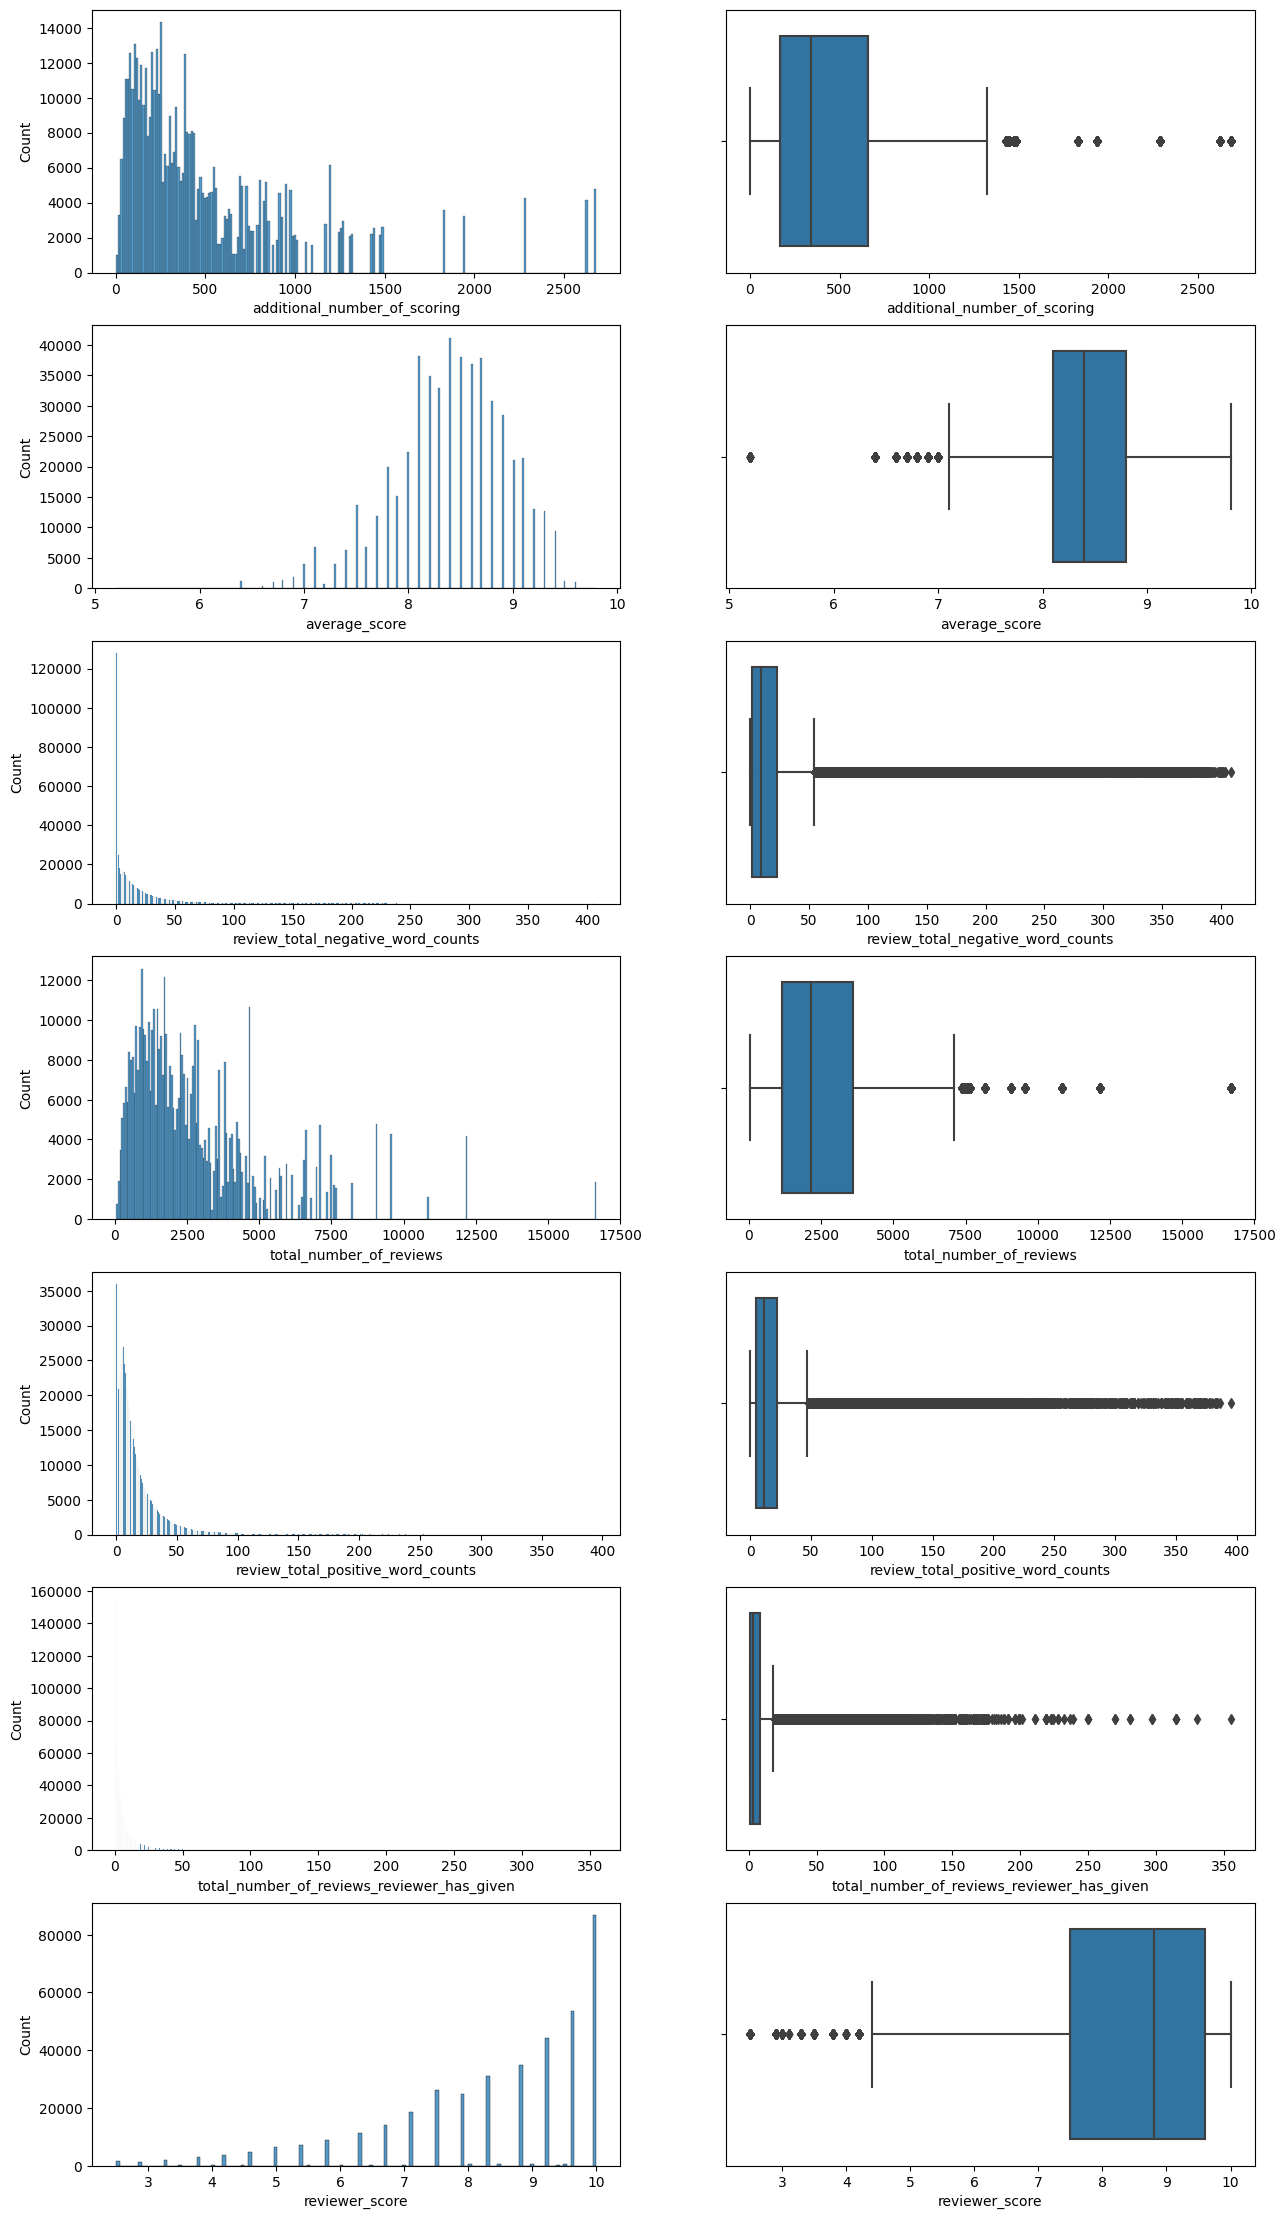

In [385]:
fig,axis = plt.subplots(nrows=7,ncols=2,figsize=(15,28))
hist_1 = sns.histplot(data=rating_hotels,x='additional_number_of_scoring',ax=axis[0][0])
boxt_1 = sns.boxplot(data=rating_hotels,x='additional_number_of_scoring',ax=axis[0][1])
hist_2 = sns.histplot(data=rating_hotels,x='average_score',ax=axis[1][0])
boxt_2 = sns.boxplot(data=rating_hotels,x='average_score',ax=axis[1][1])
hist_3 = sns.histplot(data=rating_hotels,x='review_total_negative_word_counts',ax=axis[2][0])
boxt_3 = sns.boxplot(data=rating_hotels,x='review_total_negative_word_counts',ax=axis[2][1])
hist_4 = sns.histplot(data=rating_hotels,x='total_number_of_reviews',ax=axis[3][0])
boxt_4 = sns.boxplot(data=rating_hotels,x='total_number_of_reviews',ax=axis[3][1])
hist_5 = sns.histplot(data=rating_hotels,x='review_total_positive_word_counts',ax=axis[4][0])
boxt_5 = sns.boxplot(data=rating_hotels,x='review_total_positive_word_counts',ax=axis[4][1])
hist_6 = sns.histplot(data=rating_hotels,x='total_number_of_reviews_reviewer_has_given',ax=axis[5][0])
boxt_6 = sns.boxplot(data=rating_hotels,x='total_number_of_reviews_reviewer_has_given',ax=axis[5][1])
hist_7 = sns.histplot(data=rating_hotels,x='reviewer_score',ax=axis[6][0])
boxt_7 = sns.boxplot(data=rating_hotels,x='reviewer_score',ax=axis[6][1])

Вывод:
- На графиках есть выбросы, данные оставим без изменений.


## IV.Разведовательный анализ данных.

### 1. Объектные признаки.

В разведовательном анализе расписана не вся работа. Для сокращения размера проекта по некоторым признакам будет описано, что сделали и какой был результат.

#### 1.1. Hotel_address

Из признака адресс отеля мы можем извлеч название города. 

Название стран мира и городов, мы взяли с GitHub.

In [386]:
# Считаем тексовый файл
cities = pd.read_csv('data/cities of the world.txt')

In [387]:
cities.head(3)

,city,lat,lng,country,population
0,Tokyo,35.6850,139.7514,Japan,35676000
1,New York,40.6943,-73.9249,United States,19354922
2,Mexico City,19.4424,-99.1310,Mexico,19028000


Сперва сделать так, чтобы у нас данные были в виде словаря где ключ это страна, а значение список городов. Это необходимо для функции поиска города по адресу.

In [388]:
# Создадим словарь, где ключ-страна значение-список городов
book = {}
for country in cities['country'].unique().tolist():
    l_cities = cities['city'][cities['country'] == country].unique().tolist()
    book[country] = l_cities

Создадим новый признак *country*(страна). Для этого используем функцию *country_search*.

In [389]:
# Функция поиска города по признаку hotel_address
def find_country(address):
    for country in list(book.keys()):
        # Поиск страны в адресе.
        if country in address:
            # Поиск города в адресе.
            for city in book[country]:
                if city in address:
                    return country
    return 0

Добавим новый столбец в *country*.

In [390]:
rating_hotels['country'] = rating_hotels['hotel_address'].apply(find_country)
rating_hotels.head(3)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,test,lat,lng,country
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,0,51.507894,-0.143671,United Kingdom
1,1,130 134 Southampton Row Camden London WC1B 5AF...,299,1/12/2017,8.3,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,3,1361,location,2,14,6.3,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day,0,51.521009,-0.123097,United Kingdom
2,2,151 bis Rue de Rennes 6th arr 75006 Paris France,32,10/18/2016,8.9,Legend Saint Germain by Elegancia,China,No kettle in room,6,406,No Positive,0,14,7.5,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day,0,48.845377,2.325643,France


In [391]:
# Кодируем признак порядковым кодированием.
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(rating_hotels[['country']])
data_bin.columns = ['country_i']
rating_hotels = pd.concat([rating_hotels, data_bin], axis=1)

In [392]:
rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,...,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,test,lat,lng,country,country_i
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,...,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,0,51.507894,-0.143671,United Kingdom,1


In [393]:
# Оставляем или убираем признак.
if not country_i:
    rating_hotels.drop('country_i', axis=1, inplace=True)

Вывод: 
- признак *country_i* слабо влияет на предсказание модели и у него сильная связь с признаком *lat* лучше его убрать.

#### 1.2 Review_date(дата, когда рецензент разместил соответсвующий отзыв)

Создадим признак *review_date_month* месяц в котором был сделан отзыв.

In [394]:
rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,test,lat,lng,country
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2/19/2016,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,0,51.507894,-0.143671,United Kingdom


In [395]:
# Переводим столбец 'review_date' тип данных datetime.
rating_hotels['review_date'] = pd.to_datetime(rating_hotels['review_date'])

# Добавляем столбец месяц в котором был оставлен отзыв.
rating_hotels['review_date_month'] = rating_hotels['review_date'].dt.month

In [396]:
rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,...,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,test,lat,lng,country,review_date_month
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,...,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day,0,51.507894,-0.143671,United Kingdom,2


Построим графики распределения отзывов по месяцам в году.

C:\Users\AAPun\AppData\Local\Temp\ipykernel_15172\2469087663.py:11: UserWarning:

Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.



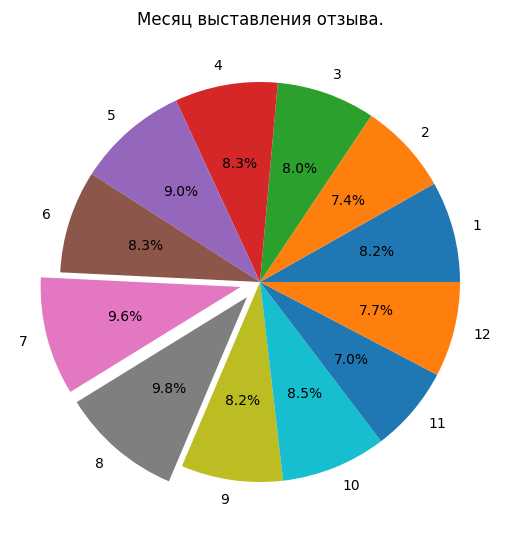

In [397]:
data = rating_hotels['review_date_month'].value_counts()
data = data.sort_index()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    data,
    labels=data.index,
    autopct='%.1f%%',
    explode=[0, 0, 0, 0, 0, 0, 0.1, 0.1, 0, 0, 0, 0])
axes.set_title('Месяц выставления отзыва.')
fig.show()

In [398]:
# Оставляем или убираем признак.
if not review_date_month:
    rating_hotels.drop('review_date_month', axis=1, inplace=True)

Вывод:
- Наибольшее число отзывов приходятся на июль и август (7 и 8 месяц). 

#### 1.3 Hotel_name(название отеля)

1.1.1. Выделим отдельный признак *famous_hotels*(популярные отели) и закодируем как 1 и 0.

In [399]:
rating_hotels['hotel_name'].describe()

count                                         515738
unique                                          1492
top       Britannia International Hotel Canary Wharf
freq                                            4789
Name: hotel_name, dtype: object

Создадим признак *famous_hotels* знаменитых отелей. Отнесём к ним 10% отелей с наибольшим числом отзывов от рецензента.

С помощью *.quantile(0.9)* найдём границу числа отзывов между 90% и 10%.

In [400]:
# Число отзывов quantile(0.9).
reviews = rating_hotels['hotel_name'].value_counts().quantile(0.9)

# Количество отелей.
result = rating_hotels['hotel_name'].value_counts(
)[rating_hotels['hotel_name'].value_counts() > reviews].count()

print(f'Кваниль_90 число отзывов: {round(reviews)}')
print(f'Число известных отелей: {result}')
print(f'Известные отели: {round(result/1492*100,2)}%')

Кваниль_90 число отзывов: 835
Число известных отелей: 150
Известные отели: 10.05%


In [401]:
# Список популярных отелей. По квантилю_90, это 835.
hotel_names = list(rating_hotels['hotel_name'].value_counts()[
                rating_hotels['hotel_name'].value_counts() > 835].index)

# Создаём новый признак famous_hotels.
rating_hotels['famous_hotels'] = rating_hotels['hotel_name'].apply(
    lambda x: 1 if x in hotel_names else 0)

# Выведем долю популярных отелей.
rating_hotels['famous_hotels'].value_counts(normalize=True)*100

0    60.288557
1    39.711443
Name: famous_hotels, dtype: float64

Известные отели состовляют около 40% из всего датафрейма. 

In [402]:
# Оставляем или убираем признак.
if not famous_hotels:
    rating_hotels.drop('famous_hotels', axis=1, inplace=True)

Вывод: 
- признак *famous_hotels* слабо влияет на предсказание модели лучше его убрать.

1.1.2. Присвоим имена мало известным отелям как *unknown* и закодируем признак порядковым кодированием.

In [403]:
# Список популярных отелей.
hotel_names = list(rating_hotels['hotel_name'].value_counts()[
    rating_hotels['hotel_name'].value_counts() > 271].index)

# Создаём новый признак famous_hotels.
rating_hotels['hotel_name_fit'] = rating_hotels['hotel_name'].apply(
    lambda x: x if x in hotel_names else 'unknown')

# Порядковое кодирование признака
ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(rating_hotels[['hotel_name_fit']])
# Переименовываем закодированный столбец.
data_bin.columns = ['hotel_name_i']
rating_hotels = pd.concat([rating_hotels, data_bin], axis=1)
# Удаляем временный столбец.
rating_hotels.drop('hotel_name_fit', axis=1, inplace=True)

In [404]:
# Оставляем или убираем признак.
if not hotel_name_i:
    rating_hotels.drop('hotel_name_i', axis=1, inplace=True)

Вывод:

#### 1.4 Reviewer_nationality(страна рецензента)

Выясним влияет ли *reviewer_nationality* на модел, т.е. когда страна рецензента совпадает с страной отеля.

In [405]:
rating_hotels['reviewer_nationality'].describe(include='object')

count               515738
unique                 227
top        United Kingdom 
freq                245246
Name: reviewer_nationality, dtype: object

In [406]:
# Убираем лишние пробелы в строке данных в начале и конце.
rating_hotels['reviewer_nationality'] = rating_hotels['reviewer_nationality'].apply(
    lambda x: x.strip())
rating_hotels['country'] = rating_hotels['country'].apply(lambda x: x.strip())

Добавим признак *match_by_nationality*, в которой 1-страна отеля и рецензента совпадает, 0-нет.

In [407]:
# определяем условия
conditions = [rating_hotels['reviewer_nationality'] == rating_hotels['country']]

# определение результата по условию в порядке conditions
choices = [1]

#create new column in DataFrame that displays results of comparisons
rating_hotels['match_by_nationality'] = np.select (conditions, choices, default=0)

#view the DataFrame
rating_hotels[['reviewer_nationality','country','match_by_nationality']].head(5)

,reviewer_nationality,country,match_by_nationality
0,United Kingdom,United Kingdom,1
1,United Kingdom,United Kingdom,1
2,China,France,0
3,United Kingdom,France,0
4,Poland,Netherlands,0


In [408]:
round(rating_hotels['match_by_nationality'].value_counts(normalize=True)*100)

0    65.0
1    35.0
Name: match_by_nationality, dtype: float64

In [409]:
# Оставляем или убираем признак.
if not match_by_nationality:
    rating_hotels.drop('match_by_nationality', axis=1, inplace=True)

Вывод:
- 35% даных имеют совпадения страна отеля и рецензента,
- .

#### 1.5 Days_since_review (количество дней между датой проверки и датой очистки)

In [410]:
rating_hotels['days_since_review'].describe()

count     515738
unique       731
top       1 days
freq        2585
Name: days_since_review, dtype: object

Даннные в признак *days_since_review* (количество дней между датой проверки и датой очистки) имеют строковый формат с припиской *day*. Преобразуем  признак и оставим лишь число дней.

In [411]:
rating_hotels['days_since_review'].describe()

count     515738
unique       731
top       1 days
freq        2585
Name: days_since_review, dtype: object

In [412]:
# Оставим в столбце 'days_since_review' только число дней.
rating_hotels['days_since_review'] = rating_hotels['days_since_review'].apply(
    lambda x: re.findall('\d+', x))
# Преобразуем данные в целое число.
rating_hotels['days_since_review'] = rating_hotels['days_since_review'].apply(
    lambda x:  int(''.join(x)))

In [413]:
rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,days_since_review,test,lat,lng,country
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,Staff were amazing,4,7,10.0,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531,0,51.507894,-0.143671,United Kingdom


In [414]:
rating_hotels['days_since_review'].describe()

count    515738.000000
mean        354.441932
std         208.928124
min           0.000000
25%         175.000000
50%         353.000000
75%         527.000000
max         730.000000
Name: days_since_review, dtype: float64

In [415]:
# Оставляем или убираем признак.
if not days_since_review:
    rating_hotels.drop('days_since_review', axis=1, inplace=True)

#### 1.6 Positive_review.

##### 1.6.1 Positive_review (Позитивный отзыв, который дал рецензент отелю)

In [416]:
rating_hotels['positive_review'].describe()

count          515738
unique         412601
top       No Positive
freq            35946
Name: positive_review, dtype: object

In [417]:
rating_hotels['positive_review'].loc[5:15]

5      Very nice hotel Price is excellent when compa...
6      Very central location 2 minutes walk from Glo...
7      The location is good for transport links espe...
8                   staff very good location wonderful 
9                                           No Positive
10     Rooms were really nice With great bathroom sh...
11     the rooms were spacious and very comfy very c...
12     Great location beautiful design very friendly...
13     Healthy breakfast friendly staff nice room va...
14                        Nice hotel very good location
15     Very comfortable hotel close to metro located...
Name: positive_review, dtype: object

Предобработка позитивных.

In [418]:
# Все отзывы в нижний пегистр.
rating_hotels['positive_review'] = rating_hotels['positive_review'].apply(
    str.lower)
# удалим все пробелы с лева.
rating_hotels['positive_review'] = rating_hotels['positive_review'].apply(
    str.lstrip)
# удалим все пробелы с права.
rating_hotels['positive_review'] = rating_hotels['positive_review'].apply(
    str.rstrip)

В позитивных отзывах видно, что некоторые из них повторяются, но есть различные формулировки. Произведём необходимые преобразования, чтобы получить определённые категории.

In [419]:
pos_rev = rating_hotels['positive_review'].value_counts().to_dict()
# Преобразуем словарь в список ключ, значение.
key = list(pos_rev.keys())
value = list(pos_rev.values())
pos_rev = list(zip(key, value))
pos_rev = [list(x) for x in pos_rev]
# Создадим DataFrame.
pos_rev = pd.DataFrame(pos_rev, columns=['positive_review', 'count'])
pos_rev.head(10)

,positive_review,count
0,no positive,35946
1,location,11945
2,everything,3314
3,nothing,1731
4,great location,1687
5,the location,1606
6,good location,1496
7,breakfast,795
8,friendly staff,733
9,excellent location,639


Создадим словарь, в котором коментарии будут относиться к определённым группам. Так к примеру *Location* и *location*, или *No Positive* и *Nothing* одно и тоже. Их следует обьединить в одну группу. Для этого создадим словарь, где ключём будет категория, а значениями возможные слова которые встречаются в отзыве.

In [420]:
# Книга обзоров.
b_review = {'location': ["location", 'view', 'position', 'central'],
            'no positive': ['nothing', 'no positive', 'not much', 'not a lot'],
            'food': ['breakfast'],
            'staff': ['staff', 'cleanliness', 'service', 'clean'],
            'comfort': ['bed', 'room', 'spa', 'hotel', 'decor', 'design', 'comfortable', 'pool',
                        'free wifi'],
            'price': ['facilities', 'price', 'value for money'],
            }

Напишем функцию которая создаст новые катерии для позитивных отзывов.

In [421]:
def review_to_category(data):
    """Присваивает имя категории изходя из отзыва.

    Args:
        data (_str_): _Принемает отзыв_

    Returns:
        _tuple_: _Возращает одну или несколько категорий_
    """
    result = []
    for category in list(b_review.keys()):
        for i in range(len(b_review[category])):
            if b_review[category][i] in data:
                result.append(category)
    if result:
        result = set(result)
    else:
        result = {'other'}
    return result

Создадим новый признак *pos_category* с помощью функции *review_to_category*.

In [422]:
rating_hotels['pos_category'] = rating_hotels['positive_review'].apply(
    review_to_category)

In [423]:
rating_hotels[['positive_review','pos_category']].head(3)

,positive_review,pos_category
0,staff were amazing,{staff}
1,location,{location}
2,no positive,{no positive}


In [424]:
rating_hotels['pos_category'].describe()

count               515738
unique                  64
top       {comfort, staff}
freq                 58869
Name: pos_category, dtype: object

Теперь у нас всего 64 группы в замен  412601 уникальным значениям в признаке *positive_review*.

Закодируем признак *pos_category* порядковым кодированием.

In [425]:
# Изменяем тип данных на строковый.
rating_hotels['pos_category'] = rating_hotels['pos_category'].astype('str')

ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(rating_hotels['pos_category'])
data_bin.columns = ['pos_category_i']
rating_hotels = pd.concat([rating_hotels, data_bin], axis=1)

# Признак 'pos_category' удяляем он больше не нежен.
rating_hotels.drop(['pos_category'], axis=1, inplace=True)

rating_hotels[['positive_review', 'pos_category_i']].head(5)

,positive_review,pos_category_i
0,staff were amazing,1
1,location,2
2,no positive,3
3,friendly staff quiet comfortable room spotless...,4
4,the staff was very friendly and helpful breakf...,5


In [426]:
# Оставляем или убираем признак.
if not pos_category_i:
    rating_hotels.drop('pos_category_i', axis=1, inplace=True)

Вывод: 
- для обработки позетивного отзыва использовалась словарь *b_review*; 
- в результате у нас вместо 412601 стало 64 уникальных значения;
- самой распространённой категорией является комфорт+персонал (*comfort, staff*).

##### 1.6.4. Проведём анализ эмоциональной окраски отзыва.

Используем библиотеку *nltk* которая определяет тональность текста, и построим на основе этого анализа признаки:

- *pos_rev_pos* позтив в позетивном отзыве;
- *pos_rev_neu* нейтральность в позетивном отзыве;
- *pos_rev_neg* негатив в позетивном отзыве;
- *pos_rev_compound* общий в позетивном отзыве.

In [427]:
# Подгружаем необходимые библиотеки.
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer

nltk.downloader.download('vader_lexicon')

sent_analyzer = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\AAPun\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [428]:
def text_analizer(data):
    """_Функция анализа тональности текста._

    Args:
        data (_str_): _коментарий_

    Returns:
        _float_: _4 значения: негатив, нейтраль, позетив, общий._
    """
    result = sent_analyzer.polarity_scores(data)
    neg = result['neg']
    neu = result['neu']
    pos = result['pos']
    compound = result['compound']
        
    return neg, neu, pos, compound

In [429]:
# Будет признак участвовать в построении модели или нет.
if tonality_of_posetive_review == 1:
    # Создание новых признаков.
    # rating_hotels['pos_rev_neg'] = rating_hotels['positive_review'].apply(
    #     text_analizer).apply(lambda x: x[0])
    # rating_hotels['pos_rev_neu'] = rating_hotels['positive_review'].apply(
    #     text_analizer).apply(lambda x: x[1])
    # rating_hotels['pos_rev_pos'] = rating_hotels['positive_review'].apply(
    #     text_analizer).apply(lambda x: x[2])
    rating_hotels['pos_rev_compound'] = rating_hotels['positive_review'].apply(
        text_analizer).apply(lambda x: x[3])

    # Описание новых признаков.
    rating_hotels[['pos_rev_compound']].describe()

In [430]:
# Пример работы текстового анализватора.
row = 5
text = rating_hotels['positive_review'].at[row] 
print(rating_hotels['positive_review'].at[row])
print(text_analizer(text))

very nice hotel price is excellent when compared to quality very quiet good food
(0.0, 0.525, 0.475, 0.8742)


Вывод: 
    
* В примере выше показана работа по определению тональности текста *positive_review*;
* по оценке *positive_review* в 5 строке:
    - 0.0 - позитивные эмоции;
    - 0.734 - нейтральные эмоции;
    - 0.266 - негативные эмоции;
    - -0.765 - общий показатель.

#### 1.7 Negative_review.

##### 1.7.1 Negative_review (Отрицательный отзыв, который дал рецензент отелю)

In [431]:
rating_hotels['negative_review'].describe()

count          515738
unique         330011
top       No Negative
freq           127890
Name: negative_review, dtype: object

In [432]:
neg_rev = rating_hotels['negative_review'].value_counts().to_dict()
# Преобразуем словарь в список ключ, значение.
key = list(neg_rev.keys())
value = list(neg_rev.values())
neg_rev = list(zip(key, value))
neg_rev = [list(x) for x in neg_rev]
# Создадим DataFrame.
neg_rev = pd.DataFrame(neg_rev, columns=['negative_review', 'count'])
neg_rev.head(3)

,negative_review,count
0,No Negative,127890
1,Nothing,14295
2,Nothing,4236


Создадим новый признак *neg_category* с помощью функции *review_to_category*.

In [433]:
rating_hotels['neg_category'] = rating_hotels['negative_review'].apply(
    review_to_category)

In [434]:
rating_hotels['neg_category'].describe()

count      515738
unique         62
top       {other}
freq       274697
Name: neg_category, dtype: object

Закодируем признак *neg_category* порядковым кодированием.

In [435]:
rating_hotels['neg_category'] = rating_hotels['neg_category'].astype('str')

ord_encoder = ce.OrdinalEncoder()
data_bin = ord_encoder.fit_transform(rating_hotels['neg_category'])
data_bin.columns = ['neg_category_i']
rating_hotels = pd.concat([rating_hotels, data_bin], axis=1)

# Признак 'pos_category' удяляем он больше не нежен.
rating_hotels.drop(['neg_category'], axis=1, inplace=True)

rating_hotels[['negative_review', 'neg_category_i']].head(5)

,negative_review,neg_category_i
0,Leaving,1
1,poor breakfast,2
2,No kettle in room,3
3,No Negative,1
4,Torn sheets,1


In [436]:
# Оставляем или убираем признак.
if not neg_category_i:
    rating_hotels.drop('neg_category_i', axis=1, inplace=True)

Вывод: 
- для обработки негативного отзыва использовалась словарь *b_review*; 
- в результате у нас вместо 330011 стало 62 уникальных значения;
- самой распространённой категорией является прочие (*other*) с числоим  повторений 274697;
- тут возможна более детальная проработка словаря *b_review*.

##### 1.7.2 Проведём анализ эмоциональной окраски негативного отзыва.

In [437]:
# Будет признак участвовать в построении модели или нет.
if tonality_of_negative_review == 1:
    # Создание новых признаков.
    # rating_hotels['neg_rev_neg'] = rating_hotels['negative_review'].apply(
    #     text_analizer).apply(lambda x: x[0])
    # rating_hotels['neg_rev_neu'] = rating_hotels['negative_review'].apply(
    #     text_analizer).apply(lambda x: x[1])
    # rating_hotels['neg_rev_pos'] = rating_hotels['negative_review'].apply(
    #     text_analizer).apply(lambda x: x[2])
    rating_hotels['neg_rev_compound'] = rating_hotels['negative_review'].apply(
        text_analizer).apply(lambda x: x[3])

    # Описание новых признаков.
    print(rating_hotels[['neg_rev_compound']].describe())

In [438]:
# Пример
text = rating_hotels['negative_review'].at[7]
print(text)
text_analizer(text)

 The communal areas are a bit soul less and the breakfast whilst very good is expensive But you can always use the cafe at the tram stop Elise I think for breakfast and late night drinks We did 


(0.072, 0.874, 0.054, -0.1787)

>Вывод:
    
* В примере выше показана работа по определению тональности текста;
* по оценке *negative_review* в 7 строке:
    - 0.072 - позитивные эмоции;
    - 0.874 - нейтральные эмоции;
    - 0.054 - негативные эмоции;
    - -0.1787 - общий показатель.

#### 1.8 Tags

Задача: построить признак важности *tags_importance*.

Этапы:
- Преобразуем данные в нужный тип.
- Построим таблицу тегов и выясним их количество.
- Определим коэффциент значимости тега *importance*, в зависимости от популярности тега.
- Добавим признак, совокупность важности тегов *tags_importance*.

##### 1.8.1 Преобразуем данные в нужный тип.

In [439]:
# Описание признака.
print(f'Тип данных в ячейке tags: {type(rating_hotels["tags"].at[0])}')

Тип данных в ячейке tags: <class 'str'>


Используем функцию *str_to_list*, чтобы перевести строку в список.

In [440]:
def str_to_list(data):
    """Строку преобразует в список.

    Args:
        data (_str_): _Строка данных_

    Returns:
        _list_: _Список текстовых фраз_
    """

    # Список символов которые нужно убрать из строки.
    symbols = ["{","}","'","[","]"]
    for symbol in symbols:
        data = data.replace(symbol,'')
        
    # Раздлим текс на список по ",".
    data = data.split(',')
    
    # Удалим пропуски в начале и в конце фразы.
    data = [i.strip() for i in data]
    
    return data

In [441]:
# Преобразуем данные.
rating_hotels['tags'] = rating_hotels['tags'].apply(str_to_list)

print(f'Тип данных в ячейке tags: {type(rating_hotels["tags"].at[0])}')

Тип данных в ячейке tags: <class 'list'>


##### 1.8.2 Построим таблицу тегов и выясним их количество.

Напишем функцию которая подсчитает и теги в каждом обзоре.

In [442]:
# Библиотека для подсчёта коллекции.
from collections import Counter
all_tags = []

def add_list_tags(data):
    all_tags.extend(data)

Соберём все теги в один список и подсчитаем их.

In [443]:
# Соберём все теги в один список
for i in range(len(rating_hotels)):
    add_list_tags(rating_hotels['tags'].at[i])

# Посчитаем теги.
all_tags = Counter(all_tags)

# Создадим df_tags.
df_tags = pd.DataFrame(data=all_tags.most_common(),columns=['tag','count'])
print(f'Всего тегов: {len(df_tags)}')
df_tags.head(3)

Всего тегов: 2428


,tag,count
0,Leisure trip,417778
1,Submitted from a mobile device,307640
2,Couple,252294


В результате все теги:
- находяться в одном *DataFrame* *df_tags*;
- отсортированы по убыванию.

##### 1.8.3 Определим коэффциент значимости тега *importance*, в зависимости от популярности тега.

In [444]:
# Сумма всех тегов
total = df_tags['count'].sum()

# Построим признак, где значение тега разделим на сумму всех тегов.
df_tags['importance'] = df_tags['count'].apply(lambda x: round((x/total),2))

In [445]:
# Оставим только теги со значением больше 1%.
df_tags = df_tags[df_tags['importance']>=0.01]

# Создадим словарь тег и его значимость.
importance = dict(zip(df_tags['tag'], df_tags['importance']))

df_tags.head(3)

,tag,count,importance
0,Leisure trip,417778,0.18
1,Submitted from a mobile device,307640,0.13
2,Couple,252294,0.11


##### 1.8.4 Добавим признак, совокупность важности тегов *tags_importance*.

In [446]:
def calculate_tag_importance(data):
    """ Функцию для подсчёта важности тега

    Args:
        data (_list_): _Список тегов_

    Returns:
        _float_: _Коэффициент совокупности важности тегов_
    """
    result = 0
    for tag in data:
        if tag in importance.keys(): result += importance[tag]
    return result

In [447]:
# Добавим признак tags_importance.
rating_hotels['tags_importance'] = rating_hotels['tags'].apply(calculate_tag_importance)

rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,test,lat,lng,country,tags_importance
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,staff were amazing,4,7,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",0,51.507894,-0.143671,United Kingdom,0.48


In [448]:
rating_hotels['tags_importance'].describe()

count    515738.000000
mean          0.361301
std           0.105920
min           0.010000
25%           0.290000
50%           0.370000
75%           0.450000
max           0.510000
Name: tags_importance, dtype: float64

In [449]:
# Построим график.
fig = px.treemap(df_tags,
                 path=['tag'],
                 values='count',
                 height=500, #высота
                 width=800, #ширина
                 title='Tags frequency')

fig.show()

In [450]:
# Оставляем или убираем признак.
if not tags_importance:
    rating_hotels.drop('tags_importance', axis=1, inplace=True)

>Вывод:
* всего 2428 тегов;
* cамые популярные *Leisure trip*, *Submitted from a mobile device* и *Couple*;
* коэффициент *tags_importance* по отелям варьируется от 0.01 до 0.51.

### 2. Новые признаки.

#### 2.1 Центр_отель удалённость.

Цель: выясним влияет ли удалённость отеля от центра города.

У нас есть адреса отелей и географические координаты широты и долготы. Для того чтобы дать ответ на поставленую задачу нужно:
- добавить новый признак *city* (город, где находится отель);
- *lat_city* и *lng_city* географические координаты центра города;
- добавим признак *center_hotel_km* (растояние между центром города и отелем).

##### 2.1.1. Добавим в таблицу новый признак *city*.

Название города есть в признаке *hotel_address*

In [451]:
rating_hotels['hotel_address'].loc[0]

'Stratton Street Mayfair Westminster Borough London W1J 8LT United Kingdom'

В примера выше в строке адресса это London. Для того чтобы создать признак *city*, используем функцию *find_city*. Используем ранее созданный в пункте 1.1 IV главы *DataFrame cities* и словарь *book*, где ключ-страна, значение-список стран. 

In [452]:
# Функция поиска города по признаку hotel_address
def find_city(address):
    for country in list(book.keys()):
        # Поиск страны в адресе.
        if country in address:
            # Поиск города в адресе.
            for city in book[country]:
                if city in address:
                    return city
    return 0

Добавим в *Rating_hotels* новый признак *city*.

In [453]:
# Добавляем признак 'city', осуществляем его поиск по адресу отеля.
rating_hotels['city'] = rating_hotels['hotel_address'].apply(find_city)

In [454]:
rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,positive_review,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,test,lat,lng,country,city
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,staff were amazing,4,7,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",0,51.507894,-0.143671,United Kingdom,London


##### 2.1.2 Найдём географические координаты центра города. В *cities* у нас есть координаты центра городов, добавим их в *rating_hotels* как признак *lat_city* и *lng_city*. Для этого:



a) Определим все значение страна-город, которые есть *rating_hotels*.

In [455]:
# Группируем данные, затем индекс переводим в список.
country_city = rating_hotels.groupby(
    ['country', 'city']).count().index.tolist()
country_city

[('Austria', 'Vienna'),
 ('France', 'Paris'),
 ('Italy', 'Milan'),
 ('Netherlands', 'Amsterdam'),
 ('Spain', 'Barcelona'),
 ('United Kingdom', 'London')]

b) С помощью фильтра сделаем выборку из таблицы *cities*.

In [456]:
city = [x[1] for x in country_city]
country = [x[0] for x in country_city]

data = cities[(cities['country'].isin(country)) & (
    cities['city'].isin(city))].drop('population', axis=1)
data

,city,lat,lng,country
19,Paris,48.8667,2.3333,France
25,London,51.5000,-0.1167,United Kingdom
56,Barcelona,41.3833,2.1834,Spain
120,Milan,45.4700,9.2050,Italy
167,Vienna,48.2000,16.3666,Austria
475,Amsterdam,52.3500,4.9166,Netherlands


c) Объединим данные построив признаки *lat_city* и *lng_city*.

In [457]:
rating_hotels = rating_hotels.merge(
    data,
    on=['country', 'city'],
    how='inner',
    suffixes=['_hotel', '_city']
)

In [458]:
rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,...,total_number_of_reviews_reviewer_has_given,reviewer_score,tags,test,lat_hotel,lng_hotel,country,city,lat_city,lng_city
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,...,7,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",0,51.507894,-0.143671,United Kingdom,London,51.5,-0.1167


##### 2.1.3. Добавим в таблицу *rating_hotels* признак *center-hotel_km* (Растояние между центром и отелем.)

Напишем функцию которая вычисляет растояние между центром города и отеля по географическим координатам, в которой используем библиотеку *geopy.distance*.

In [459]:
# Библиотека для определения географических координат.
from geopy.distance import great_circle as GC

In [460]:
def find_distance(data):
    """Находим растояние между центром и отелем.

    Args:
        data (_dict_): Передаём словарь с координатами точек.

    Returns:
        _float_: Возвращаем расстояние в (км) округлённое до двух.
    """
    # Заносим координаты центра и отеля.
    center = [data['lat_city'], data['lng_city']]
    hotel = [data['lat_hotel'], data['lng_hotel']]
    # Определям координаты.
    distance = GC(center, hotel)
    # Значения округлим до 2
    return round((float('.'.join(re.findall('\d+', str(distance))))), 2)

In [461]:
# В новый столбец занесём данные из нескольких столбцов в виде словаря.
rating_hotels['center_hotel_km'] = rating_hotels[['lat_city',
                                                  'lng_city',
                                                  'lat_hotel',
                                                  'lng_hotel']].agg(dict, axis=1)

# Определи растояние на основе географических координат.
rating_hotels['center_hotel_km'] = rating_hotels['center_hotel_km'].apply(
    find_distance)
rating_hotels['center_hotel_km'].head(3)

0    2.06
1    2.38
2    4.78
Name: center_hotel_km, dtype: float64

In [462]:
rating_hotels['center_hotel_km'].describe()

count    515738.000000
mean          3.453546
std           2.749409
min           0.060000
25%           1.660000
50%           2.930000
75%           4.630000
max          82.920000
Name: center_hotel_km, dtype: float64

Text(0.5, 1.0, 'Растояние между центром города и отелем.')

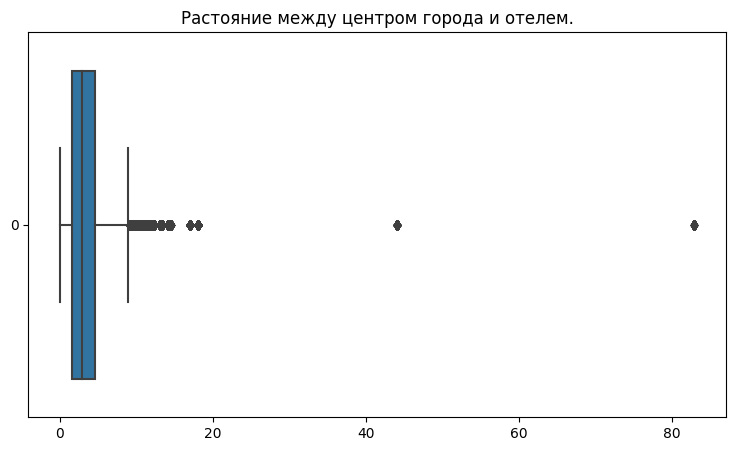

In [463]:
fig = plt.subplots(figsize=(9, 5))
fig = sns.boxplot(rating_hotels['center_hotel_km'], orient='h')
fig.set_title('Растояние между центром города и отелем.')

Вывод:
- в среднем растояние между центром городы и отелем от 0 до 5 км;
- на графике, есть выбросы, мы оставляем как есть;
- растояние от центра до отеля не внесли существенных улучшений в предсказательность модели.

In [464]:
# Оставляем или убираем признак.
if not center_hotel_km:
    rating_hotels.drop(['center_hotel_km'], axis=1, inplace=True)

#### 2.2 Климатические условия.

Цель: выяснить влияет ли погода на тот момент когда был оставлен отзыв.

Для этого воспользуемся сайтом [openweathermap](https://openweathermap.org/).

Сайт позволяет получить данные о погоде:
* *temp* - температура;
* *feels_like* - как ощущается температура;
* *pressure* - атмасферное давление;
* *humidity* - влажность;
* *wind_speed* - скорость ветра;
* *wind_deg* - откуда дует ветер;
* *clouds* - облачность;
* *visibility* - видимость. 

В запрос необходимо передать:
- географические координаты широты и долготы;
- *unix_time*, исторический момент времени;
- *api_key*

Для того чтобы дать ответ на поставленую задачу нужно:
- определить *unix_time* (время по системе *UNIX*);
- создать временную сгрупированную таблицу данных;
- получим данные с сайта и занесём во временную таблицу;
- объединить данные создав новые признаки.

##### 2.2.1 Определим *unix_time*.

Напишем функции для перевода даты *review_data*  в секунды *unix_time*.

In [465]:
def find_unix_time(date):
    """Функция переводит дату в секунды.

    Args:
        date (_str_): Принимае дату в виде строки

    Returns:
        _int_: Время в секундах
    """
    date = list(map(int, date.split('-')))
    year = date[0]
    month = date[1]
    day = date[2]
    unix_time = int(datetime.datetime(
        year=year, month=month, day=day).timestamp())
    return unix_time

Добавим новый столбец *unix_time*, используя признак *review_date*. Он нам необходим для запроса к сайту погоды.

In [466]:
rating_hotels['review_date'].info

<bound method Series.info of 0        2016-02-19
1        2017-01-12
2        2017-05-18
3        2015-11-24
4        2016-02-02
            ...    
515733   2017-04-05
515734   2015-10-07
515735   2017-06-01
515736   2015-11-17
515737   2016-06-18
Name: review_date, Length: 515738, dtype: datetime64[ns]>

In [467]:
# Изменяем тип данных на 'str'.
rating_hotels['review_date'] = rating_hotels['review_date'].astype('str')

# Добавляем новый столбец 'unix_time'.
rating_hotels['unix_time'] = rating_hotels['review_date'].apply(find_unix_time)

In [468]:
rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,...,reviewer_score,tags,test,lat_hotel,lng_hotel,country,city,lat_city,lng_city,unix_time
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,...,10.0,"[Leisure trip, Couple, Studio Suite, Stayed 2 ...",0,51.507894,-0.143671,United Kingdom,London,51.5,-0.1167,1455829200


In [469]:
rating_hotels[['country', 'city','review_date','unix_time']].head(1)

,country,city,review_date,unix_time
0,United Kingdom,London,2016-02-19,1455829200


2.2.2 Временная таблица данных.

Как мы уже знаем наш *rating_hotels* содержит болле 500 тысяч строк. Необходимо сгрупировать данные, чтобы сократить количество запросов, до минимального. 

Надо понимать это существенно ускорит процесс получение необходимой информации, но также сократит время её получение. 

In [470]:
print(f'Число строк: {rating_hotels.shape[0]}')

Число строк: 515738


2.2.3 Получим данные с сайта и занесём во временную таблицу.

Напишем функцию запроса для получение данных о погоде.

Данные были получены с сайта [openweathermap](https://openweathermap.org/). Часть кода была закоментирована, т.к. данные были получены не за один день и занесены в файл *weather.csv*.

In [471]:
# def fetch_weather(data):
#     """Функция делает запрос на сайт погоды, и возвращает словарь с знаяениями.

#     Args:
#         data (_dict_): _Принимает словарь с параметрами._

#     Returns:
#         _dict_: _Возвращает словарь со значениями._
#     """
#     # параметры запроса
#     lat = data['lat_city']       # широта
#     lon = data['lng_city']       # долгота
#     dt = data['unix_time']        # дата в секундах

#     weather = {}

#     # Код запроса погоды на определённый промежуток времени.
#     base_url = "https://api.openweathermap.org/data/2.5/weather?"
#     response = requests.get(base_url, params={
#         "lat": lat,
#         "lon": lon,
#         "dt": dt,
#         "appid": api_key['weather'],
#         "format": "json",
#     })

#     # зансим данные в словарь значения по катего
#     weather['temp'] = response.json()['main']['temp']
#     weather['feels_like'] = response.json()['main']['feels_like']
#     weather['pressure'] = response.json()['main']['pressure']
#     weather['humidity'] = response.json()['main']['humidity']
#     weather['wind_speed'] = response.json()['wind']['speed']
#     weather['wind_deg'] = response.json()['wind']['deg']
#     weather['clouds'] = response.json()['clouds']['all']
#     weather['visibility'] = response.json()['visibility']

#     return weather

Создадим выборку из *rating_hotels* по всем историческим моментам времени.

In [472]:
# Группировка по признакам cols.
cols = ['country', 'city', 'lat_city', 'lng_city', 'unix_time']
selection = rating_hotels[cols].groupby(cols).count().index.to_list()
rating_hotels[cols].groupby(cols).count().index.to_list()

# Переводим в DataFrame.
selection = pd.DataFrame(selection, columns=cols)
selection.head(3)

,country,city,lat_city,lng_city,unix_time
0,Austria,Vienna,48.2,16.3666,1438635600
1,Austria,Vienna,48.2,16.3666,1438722000
2,Austria,Vienna,48.2,16.3666,1438808400


In [473]:
len(selection)

4386

Сделав выборку у нас получилось 4386 строк вместо 515738, так мы сократили число запросов не потеряв информативность данных. Далее обратимся к сайт для получения информации о погоде.

Уникальность скрипта⬇️ в том, что указав число запросов в *api_limit* будет происходить заполнение *selection['weather']*, только в пустые ячейки.

In [474]:
# # Условие заполнения признака.
# if 'weather' not in selection.columns:
#     selection['weather'] = 0

# # Ограничение на поиск по api запросам в день 1000.
# api_limit = 0

# for row in range(len(selection)):
#     # Условие если по строке row в ячейке weather 0 и лимит по api больше 0.
#     if selection['weather'].loc[row] == 0 and api_limit > 0:

#         # Передаём значения в функцию fetch_weather в виде словаря данных из строки.
#         selection['weather'].at[row] = fetch_weather(
#             selection.loc[row].to_dict())
#         print(selection['weather'].at[row])
#         # Устанавливаем задержку для регулирования запросов с сайта
#         # 60 запросов в минуту.
#         time.sleep(1)
#         api_limit -= 1

Данные были получены не за один раз поэтому они были занесены в файл *weather.csv*. Считаем их.

In [475]:
# selection.head(1)

In [476]:
selection = pd.read_csv(DATA_DIR+'weather.csv')

In [477]:
selection.head(3)

,country,city,lat_city,lng_city,unix_time,weather,review_date
0,Austria,Vienna,48.2,16.3666,1438635600,"{'temp': '292.19', 'feels_like': '291.61', 'pr...",2015-08-04
1,Austria,Vienna,48.2,16.3666,1438722000,"{'temp': '292.19', 'feels_like': '291.61', 'pr...",2015-08-05
2,Austria,Vienna,48.2,16.3666,1438808400,"{'temp': '292.19', 'feels_like': '291.61', 'pr...",2015-08-06


При сохранении(*pd.to_csv*) и извлечении(*pd.read_csv*) данных может произойти так что часть, будет иметь тип 'str', другая 'dict'. Для этого прописал скрип ниже⬇️.

In [478]:
def str_to_dict(a):
    """Преобразует строку в словарь

    Args:
        a (_str_): _строка_

    Returns:
        _dict_: _словарь_
    """
    # список символов которые нужно убрать из строки
    temp = ["{", "}", "'", " "]
    for symbol in temp:
        a = a.replace(symbol, '')
    # Преобразуем в [[],[],...], т.е. [название колонки, значение].
    a = [res.split(':') for res in a.split(',')]
    a = dict(a)
    return a

In [479]:
# Преобразуем тип признака в 'str'.
selection['weather'] = selection['weather'].astype('str')
# Преобразуем признака в 'dict'.
selection['weather'] = selection['weather'].apply(str_to_dict)

In [480]:
print(f"Тип данных в признаке weather: {type(selection['weather'].loc[0])}")

Тип данных в признаке weather: <class 'dict'>


2.2.4 Создаём новые признаки *weather* и объединяем данные.

In [481]:
selection.head(1)

,country,city,lat_city,lng_city,unix_time,weather,review_date
0,Austria,Vienna,48.2,16.3666,1438635600,"{'temp': '292.19', 'feels_like': '291.61', 'pr...",2015-08-04


In [482]:
# Вытаскивыет параметры из признака 'weather' и заносит их в нужную колонку (температура, вляжность, давление, и т.д.)
# Новые признаки которые будут добавлены
cols = ['temp', 'feels_like', 'pressure', 'humidity',
        'wind_speed', 'wind_deg', 'clouds', 'visibility']

# Добавлям признак если его нет selection.
for column in cols:
    if column not in selection.columns:
        selection[column] = 0

for row in range(len(selection)):
    check = selection['weather'].at[row]
    for key in check.keys():
        selection[key].at[row] = check[key]

selection.head(1)

,country,city,lat_city,lng_city,unix_time,weather,review_date,temp,feels_like,pressure,humidity,wind_speed,wind_deg,clouds,visibility
0,Austria,Vienna,48.2,16.3666,1438635600,"{'temp': '292.19', 'feels_like': '291.61', 'pr...",2015-08-04,292.19,291.61,1018,56,8.94,319,0,10000


Знесём данные в *rating_hotels*.

In [483]:
# Оставим только колонки которые хитим добавить.
data = selection.drop(['lat_city', 'lng_city', 'weather','unix_time'], axis=1)

# Знесим данные в *rating_hotels*.
rating_hotels = rating_hotels.merge(
    data,
    how='left',
    on=['country', 'city', 'review_date'],
)

rating_hotels.head(1)

,index,hotel_address,additional_number_of_scoring,review_date,average_score,hotel_name,reviewer_nationality,negative_review,review_total_negative_word_counts,total_number_of_reviews,...,lng_city,unix_time,temp,feels_like,pressure,humidity,wind_speed,wind_deg,clouds,visibility
0,0,Stratton Street Mayfair Westminster Borough Lo...,581,2016-02-19,8.4,The May Fair Hotel,United Kingdom,Leaving,3,1994,...,-0.1167,1455829200,287.11,286.68,1024,81,4.63,240,99,10000


Изменим типы данных для погоды, иначе они не будут участвовать в построении модели.

In [484]:
# Все признаки погоды и их типы данных.
weather_types = {'temp':'float16','feels_like':'float16','pressure':'int16',
                'humidity':'int16','wind_speed':'float16','wind_deg':'int16',
                'clouds':'int16','visibility':'int16'}

In [485]:
# Типы данных погоды, как было.
rating_hotels[list(weather_types.keys())].dtypes

temp          object
feels_like    object
pressure      object
humidity      object
wind_speed    object
wind_deg      object
clouds        object
visibility    object
dtype: object

In [486]:
if weather:
    rating_hotels = rating_hotels.astype(weather_types)
    

In [487]:
# Типы данных погоды, как стало.
rating_hotels[list(weather_types.keys())].dtypes

temp          float16
feels_like    float16
pressure        int16
humidity        int16
wind_speed    float16
wind_deg        int16
clouds          int16
visibility      int16
dtype: object

In [488]:
# Оставляем или убираем признак.
if not weather:
    rating_hotels.drop(['temp', 'feels_like', 'pressure', 'humidity',
                        'wind_speed', 'wind_deg', 'clouds', 'visibility'], axis=1, inplace=True)
    


Вывод:
- Данные о погоде не внесли существенных улучшений в предсказательность модели.

## Нормализация признаков.

Посмотрим как даннные выгледят сейчас на графике.

In [489]:
# Библиотеки применяемые в этом разделе.
from sklearn import preprocessing

In [490]:
def create_graph(df):
    """Функция строит общий график по все колонкам в DataFrame

    Args:
        df (_DataFrame_): Таблица с признаками которую хотим отобразить;
    """
    
    fig, axes = plt.subplots(nrows=1, figsize=(10, 8))
    axes.set_title('Общий график')

    for colum in df.columns:
        sns.kdeplot(data=df[colum], ax=axes, label=colum)
    plt.legend()
    return 0

Построим общий график, без нормолизации. В *drop_cols* занесём признаки которые исключим.

In [491]:
rating_hotels.columns

Index(['index', 'hotel_address', 'additional_number_of_scoring', 'review_date',
       'average_score', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'review_total_negative_word_counts',
       'total_number_of_reviews', 'positive_review',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'reviewer_score', 'tags',
       'test', 'lat_hotel', 'lng_hotel', 'country', 'city', 'lat_city',
       'lng_city', 'unix_time', 'temp', 'feels_like', 'pressure', 'humidity',
       'wind_speed', 'wind_deg', 'clouds', 'visibility'],
      dtype='object')

C:\Users\AAPun\AppData\Local\Temp\ipykernel_15172\584324612.py:12: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.

C:\Users\AAPun\AppData\Local\Temp\ipykernel_15172\584324612.py:12: UserWarning:

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.



0

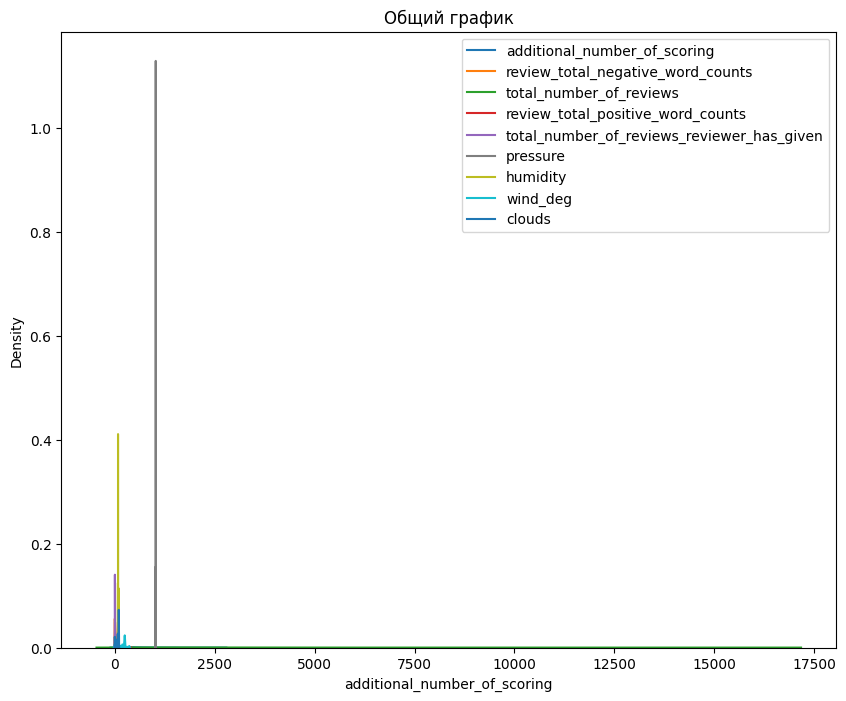

In [492]:
# Построим общий график.
# Исключаем данные которые не будут нормализованы.
drop_cols = ['index', 'unix_time', 'lat_city', 'lng_city',
            'country_i', 'hotel_name_i', 'pos_category_i',
            'neg_category_i', 'test', 'famous_hotels',
            'match_by_nationality', 'lat_hotel', 'lng_hotel',
            'visibility','review_date_month','average_score',
            'reviewer_score','wind_speed','tags_importance']

numeric = ['int16','int32','int64',
        'float16','float32','float64']

# Удалим колонки из списка если они есть.
temp = drop_cols.copy()
for col in temp:
    if col not in rating_hotels.columns:
        drop_cols.remove(col)

df = rating_hotels.select_dtypes(include=numeric).copy()
df = df.drop(drop_cols,axis=1)
create_graph(df)

Нормализуем признаки и построим график снова. 

Для этого:
1) Выделим данные которые будут нормализованы.

In [493]:
# Выделим объетные признаки, числовые и те которые нормализуем.        
df = rating_hotels.select_dtypes(include=numeric).copy()

# Dataframe только с объектными признаками.
df_object = rating_hotels.select_dtypes(include='object').copy()
# Числовые признаки, которые ёбудут нормализованы.
df_change = df.drop(drop_cols,axis=1)
# Числовые признаки, которые не будут нормализованы.
df_no_change = df[drop_cols]

2) Выбираем тип нормализации.

In [494]:
# Сохраним список колонок.
col_names = list(df_change.columns)

# Выбираем нормализацию или стандартизацию.
scaler_type = 1

# Условия выбора преобразования.
if scaler_type == 1:
    # инициализируем нормализатор MinMaxScaler
    scaler = preprocessing.MinMaxScaler()
elif scaler_type == 2:
    # инициализируем нормализатор RobustScaler
    scaler = preprocessing.RobustScaler()
elif scaler_type == 3:
    # инициализируем стандартизатор StandardScaler
    scaler = preprocessing.StandardScaler()

3) Строим график.

0

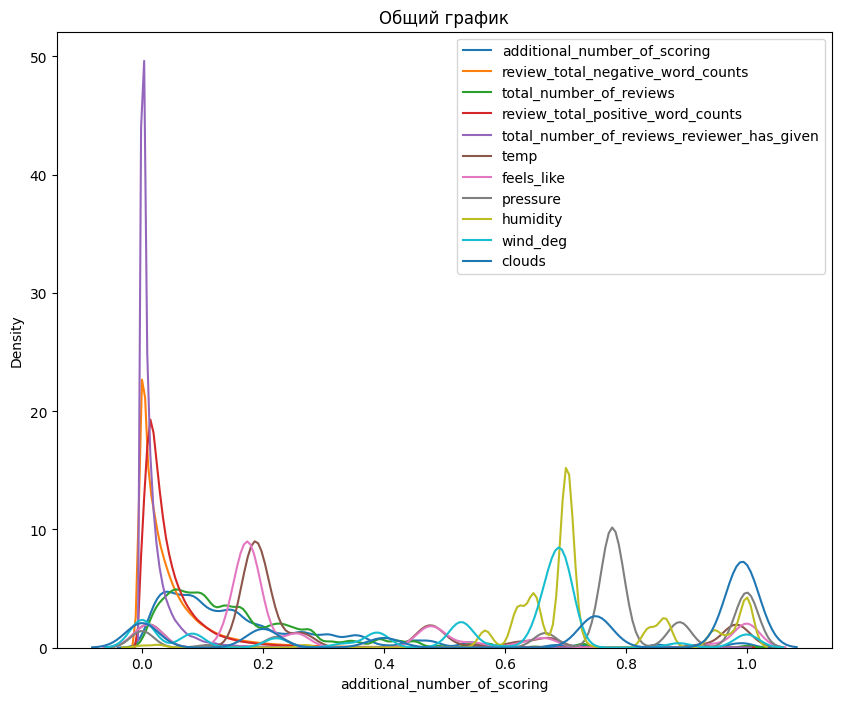

In [495]:
# Кодируем исходный датасет.
df_change = scaler.fit_transform(df_change)

# Преобразуем промежуточный датасет в полноценный датафрейм для визуализации.
df_change = pd.DataFrame(df_change, columns=col_names)

# Строим график.
create_graph(df_change)

Ниже приведены признаки после нормализации.

In [496]:
df_change.describe()

,additional_number_of_scoring,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,temp,feels_like,pressure,humidity,wind_deg,clouds
count,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000,515738.000000
mean,0.185409,0.045440,0.162431,0.045004,0.017418,0.336149,0.328862,0.748882,0.741228,0.528525,0.686752
std,0.186698,0.072772,0.139380,0.055200,0.031187,0.289447,0.297013,0.267082,0.153043,0.279998,0.382274
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.062663,0.004902,0.067240,0.012658,0.000000,0.183673,0.176471,0.777778,0.648649,0.388889,0.200000
50%,0.126818,0.022059,0.125759,0.027848,0.005650,0.183673,0.176471,0.777778,0.702703,0.666667,0.990000
75%,0.245804,0.056373,0.214711,0.055696,0.019774,0.469388,0.470588,0.888889,0.837838,0.694444,0.990000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [497]:
print(f'Всего нормализованных признаков: {len(df_change.columns)}')

Всего нормализованных признаков: 11


Вывод:
- теперь данные имеют более наглядный вид.

Объединям в один DataFrame все признаки включая нормализованные.

In [498]:
rating_hotels = pd.concat([df_object,df_no_change,df_change],axis=1)

## V. Моделирование.

Цель: Обучить модель на тренировачных данных и предсказать *reviewer_score* (оценку, которую мог бы поставить рецензент).

Для этого нужно:

1. Разделить *rating_hotels* на тренировочные и тестовые данные, которые мы объеденили в самом начале, для построения новых признаков.
2. Удалить столбцы с типом данных *object*, т.к. модель воспринемает только числовые признаки.
3. Разбить тренеровочные данные на X - данные с информацией об отелях, y - целевую переменную.
4. Предсказть *reviewer_score* для тестовых данных и сохранить результат *submition*. 


### 1. Разделение данныx.

In [499]:
rating_hotels.columns

Index(['hotel_address', 'review_date', 'hotel_name', 'reviewer_nationality',
       'negative_review', 'positive_review', 'tags', 'country', 'city',
       'index', 'unix_time', 'lat_city', 'lng_city', 'test', 'lat_hotel',
       'lng_hotel', 'visibility', 'average_score', 'reviewer_score',
       'wind_speed', 'additional_number_of_scoring',
       'review_total_negative_word_counts', 'total_number_of_reviews',
       'review_total_positive_word_counts',
       'total_number_of_reviews_reviewer_has_given', 'temp', 'feels_like',
       'pressure', 'humidity', 'wind_deg', 'clouds'],
      dtype='object')

In [500]:
# Удаляем временные признаки.
rating_hotels.drop(['unix_time', 'lat_city', 'lng_city'], axis=1, inplace=True)

# Удаляем признаки которые дают мултиколенарность.
rating_hotels.drop(['additional_number_of_scoring'], axis=1, inplace=True)

In [501]:
# Округлим значения в координатах до 2. Это улучшит модель.
rating_hotels['lat_hotel'] = rating_hotels['lat_hotel'].round(2)
rating_hotels['lng_hotel'] = rating_hotels['lng_hotel'].round(2)


Разделим тернировочные и тестовые данные.

In [502]:
# Разбиваем данные на тенировочные и тестовые как было.
df_train = rating_hotels[rating_hotels['test'] == 0]
df_test = rating_hotels[rating_hotels['test'] == 1]

# С сортируем по признаку index, и задаём его в качстве index.
df_train = df_train.sort_values(by='index', axis=0).set_index('index')
df_test = df_test.sort_values(by='index', axis=0).set_index('index')

# Убираем признак тест
df_train.drop('test', axis=1, inplace=True)
df_test.drop('test', axis=1, inplace=True)

### 2. Удаление столбцов с типом данных *object*.

In [503]:
# Модель на признаках с dtypes "object" обучаться не будет,
# просто выберим их и удалим.
# Выделяем список обектных признаков.
object_columns = [
    s for s in df_train.columns if df_train[s].dtypes == 'object']

# Удаляем объектные признаки из тренировочного DataFrame.
df_train.drop(object_columns, axis=1, inplace=True)

# Удаляем объектные признаки из тестового DataFrame.
df_test.drop(object_columns, axis=1, inplace=True)

### 3. Разбиваем тренировочные данные на X - данные с информацией об отелях, y - целевая переменная.

In [504]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели.
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)
X = df_train.drop(['reviewer_score'], axis=1)
y = df_train['reviewer_score']

In [505]:
df_train.describe()

,lat_hotel,lng_hotel,visibility,average_score,reviewer_score,wind_speed,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,temp,feels_like,pressure,humidity,wind_deg,clouds
count,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000,386803.000000
mean,49.433360,2.892128,9287.126780,8.397231,8.396906,NaN,0.045439,0.162446,0.045005,0.017450,0.336219,0.328937,0.748802,0.741312,0.528235,0.687115
std,3.460976,4.665930,2278.893235,0.547881,1.636090,0.000000,0.072802,0.139319,0.055003,0.031227,0.289383,0.296964,0.267123,0.152697,0.279881,0.381993
min,41.330000,-0.370000,700.000000,5.200000,2.500000,0.509766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.210000,-0.140000,10000.000000,8.100000,7.500000,2.060547,0.004902,0.067240,0.012658,0.000000,0.183673,0.176471,0.777778,0.648649,0.388889,0.200000
50%,51.500000,0.020000,10000.000000,8.400000,8.800000,4.628906,0.022059,0.125759,0.027848,0.005650,0.183673,0.176471,0.777778,0.702703,0.666667,0.990000
75%,51.520000,4.840000,10000.000000,8.800000,9.600000,4.628906,0.056373,0.214711,0.055696,0.019774,0.469388,0.470588,0.888889,0.837838,0.694444,0.990000
max,52.400000,16.430000,10000.000000,9.800000,10.000000,8.937500,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3. Обучение модели.

In [506]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [507]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [508]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

# Создаём модель
model = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

Изначально MAPE: 0.14138286324223787 , попробуем улучшить модель предсказаний.

1. После добавления координат MAPE: 0.140456387881512
2. Округлили *lat* и *lng* до 2-х MAPE: 0.1387281800226659
3. Добавили столбец 'review_date_month' MAPE: 0.13830949387381158
4. Преобразовали значения в столбец 'days_since_review': MAPE: 0.1369233052320562
5. Провели нормализацию признаков MinMaxScaler и оставили часть колонок без изменений MAPE: 0.13683918988685917
6. Данные о погоде(давление вляжность, температура, скорость ветра и т.д.), не внесли изменений в модель. 

Стало MAPE: 0.13682293619549685

нормализация по MinMaxScaler MAPE: 0.13676311700439192

нормализация по RobustScaler MAPE: 0.13701558046749338

нормализация по StandarScaler MAPE: 0.1370



MAPE: 0.13171005418908316 
Удаляем признаки с сильной связью.

In [509]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.
print('MAPE:', metrics.mean_absolute_percentage_error(y_test, y_pred))

MAPE: 0.1399863605710342


Фукция расчёта Mean Absolute Error.

In [510]:
def MAPE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true))*100

In [511]:
result = MAPE(y_test,y_pred)
print('MAPE:', result)

MAPE: 13.99863605710342


Когда только *pos_rev_compound*, , то MAPE: 12.58

Когда все признаки *positive_review*, то MAPE: 12.566636882222534

Когда только *pos_rev_compound* и *neg_rev_cmpound*, то MAPE: 12.301218731069142

Когда все признаки *positive_review* и *negative_review*, то MAPE: 12.238945287155158



Фукция расчёта Mean Absolute Error.

In [512]:
def MAE(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred))

In [513]:
result = MAE(y_test,y_pred)
print('MAE:', result)

MAE: 0.9715722920173827


Убрать признаки которые дают мультиколенарность:
additional_number_of scoring

<AxesSubplot: >

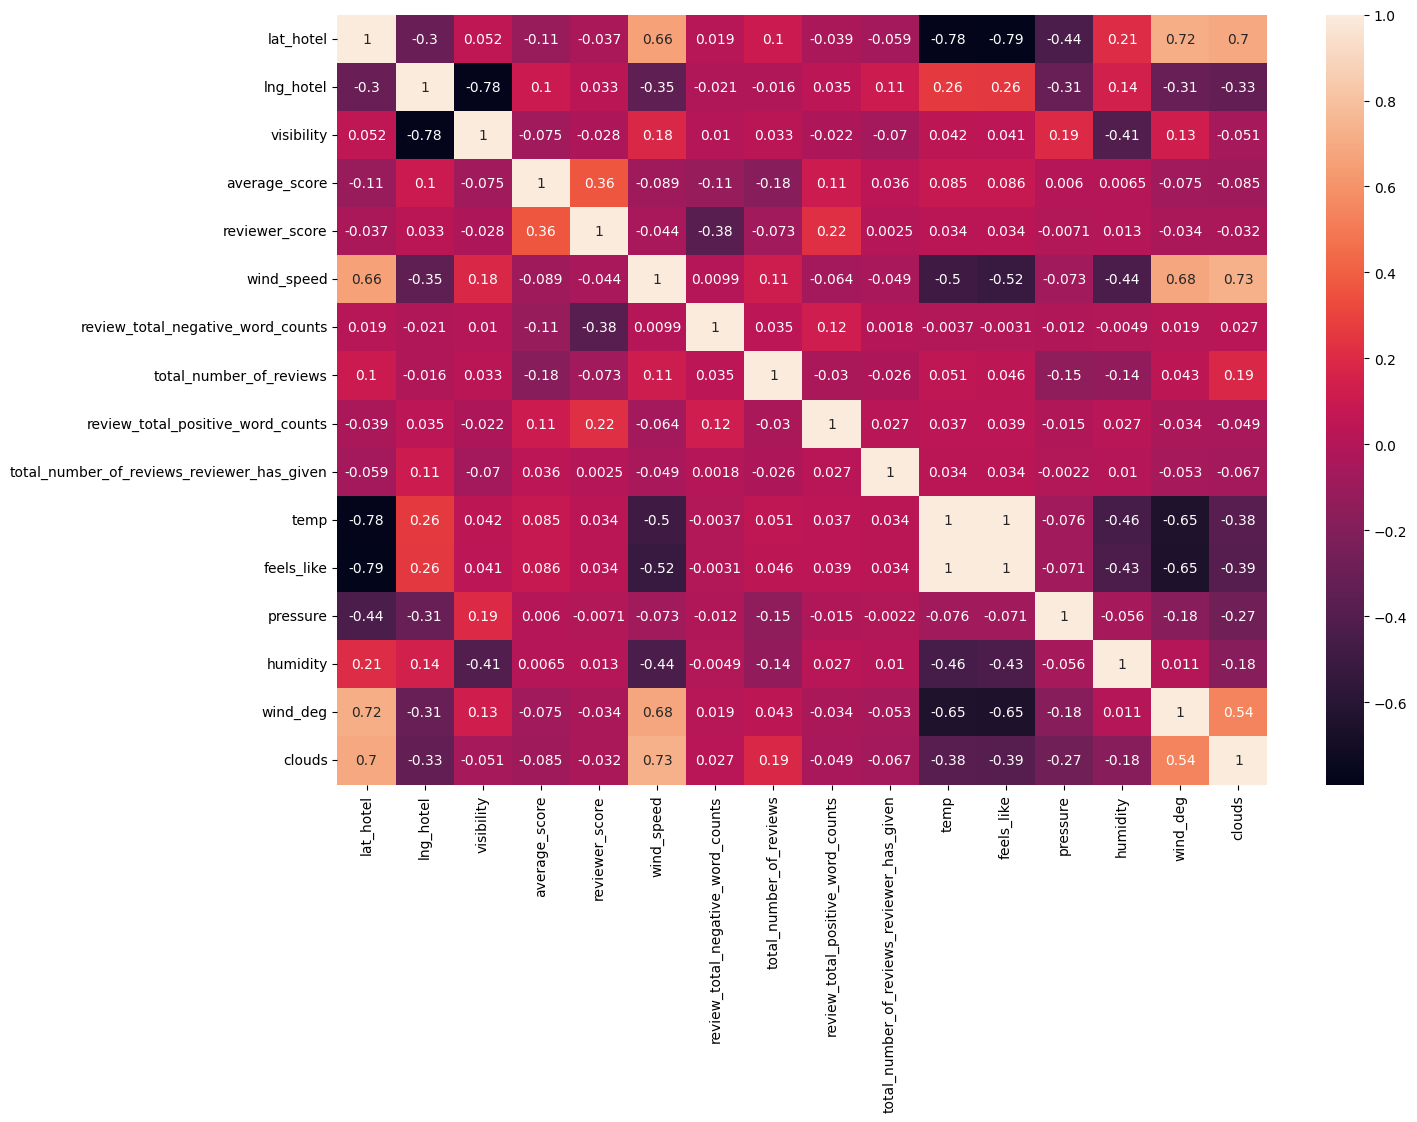

In [514]:
plt.rcParams['figure.figsize'] = (15, 10)
sns.heatmap(df_train.corr(), annot=True)

<AxesSubplot: >

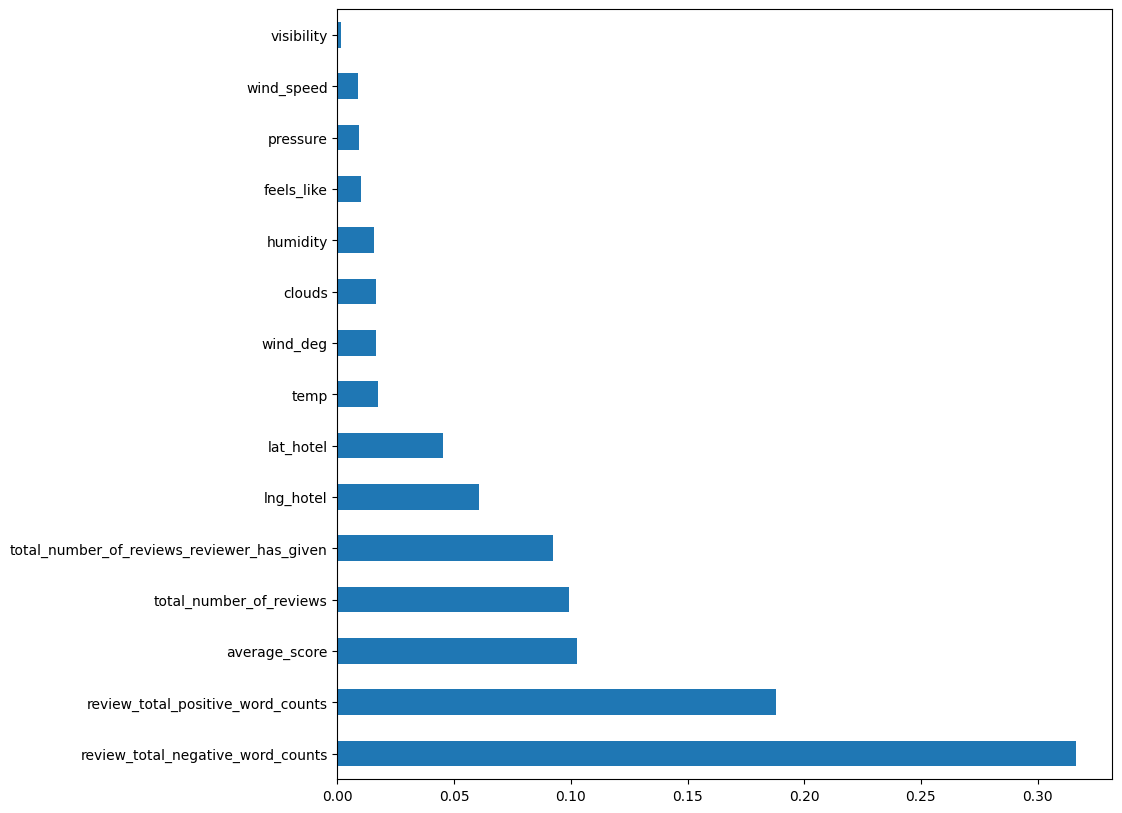

In [515]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10, 10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

Вывод: 
- График выше показывает, как сильно то или иной признак влияет на модель предсказаия.

>В данном проекте мы добовляли и другие признаки, которые сюда не вошли. Ввиду того, что их наличие не внесли существенного влияния на предсказательную модель, они были опущены. К их числу  относятся:

- Кодирование призака города.

### 4. Прогнозирование. Сохранение решения.

In [516]:
# Сбрасываем признак который необходимо предсказать.
df_test.drop(['reviewer_score'],axis=1,inplace=True)

In [517]:
predict_submission = model.predict(df_test)

In [518]:
list(sample_submission)

['reviewer_score', 'id']

In [519]:
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv(DATA_DIR+'submission.csv', index=False)
sample_submission.head(5)

,reviewer_score,id
0,8.709000,488440
1,7.513000,274649
2,8.589000,374688
3,9.434000,404352
4,9.149925,451596


In [520]:
print("Process finished --- %s seconds ---" % (time.time() - start_time))
print(f"Всего: {round(((time.time() - start_time)/60),2)} минут.")

Process finished --- 260.05419063568115 seconds ---
Всего: 4.33 минут.
